In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import matplotlib.pyplot as plt

df=pd.read_csv('MaunaLoaDailyTemps.csv',index_col='DATE' ,parse_dates=True)
df=df.dropna()
df.head()
df

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758
...,...,...,...,...,...
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753


In [2]:
print('Shape of data',df.shape)

Shape of data (1821, 5)


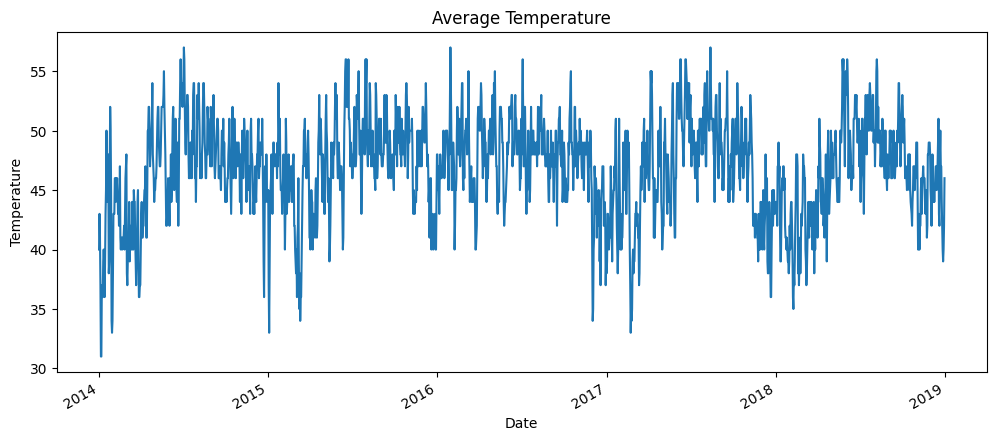

In [3]:
df['AvgTemp'].plot(figsize=(12, 5))
plt.title('Average Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

In [4]:
# Preprocess the data
data = df['AvgTemp'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [5]:
sequence_length = 30  # how many previous time steps are considered when predicting the temperature at the current time step.

Creates sequences of 30 days as input features and the temperature of the next day as the target value.

In [6]:
# Prepare data for training
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length, 0])
    y.append(data_scaled[i+sequence_length, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  #(number of samples, sequence length=30, number of features=1)
X.shape

(1791, 30, 1)

In [7]:
# Split the dataset into training and testing sets
split = int(0.8 * len(data_scaled))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(X.shape[1], 1), activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1361 (5.32 KB)
Trainable params: 1361 (5.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1456, 30, 1)
X_test shape: (335, 30, 1)
y_train shape: (1456,)
y_test shape: (335,)


In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
test_predictions_scaled = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions_scaled).flatten()

Epoch 1/50

41/41 [==============================] - 3s 17ms/step - loss: 0.4799 - val_loss: 0.1444
Epoch 2/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0589 - val_loss: 0.0188
Epoch 3/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0151
Epoch 4/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 5/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0158
Epoch 6/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0139 - val_loss: 0.0123
Epoch 7/50
41/41 [==============================] - 0s 7ms/step - loss: 0.0136 - val_loss: 0.0122
Epoch 8/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 9/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.0129
Epoch 10/50
41/41 [==============================] - 0s 8ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 11/50
41/41

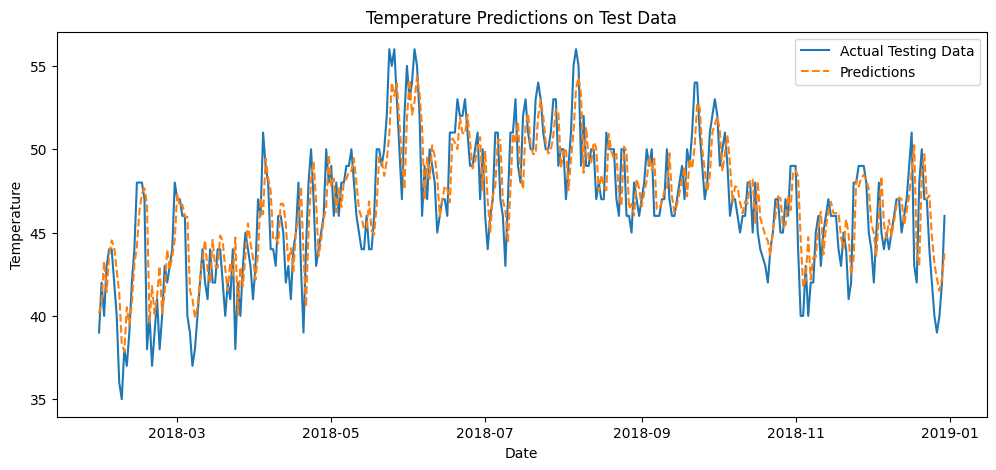

In [11]:
# Plotting predictions vs. actual
plt.figure(figsize=(12, 5))
plt.plot(df.index[split+sequence_length:], df['AvgTemp'][split+sequence_length:], label='Actual Testing Data')
plt.plot(df.index[split+sequence_length:], test_predictions, label='Predictions', linestyle='dashed')
plt.title('Temperature Predictions on Test Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [14]:
# Calculating RMSE for test predictions
from sklearn.metrics import mean_squared_error
from math import sqrt

test_actual_temps = df['AvgTemp'][split + sequence_length:].values
test_mse = mean_squared_error(test_actual_temps, test_predictions)
test_rmse = sqrt(test_mse)

print(f"Root Mean Squared Error (RMSE) on Test Data: {test_rmse}")


Root Mean Squared Error (RMSE) on Test Data: 2.233917108323458


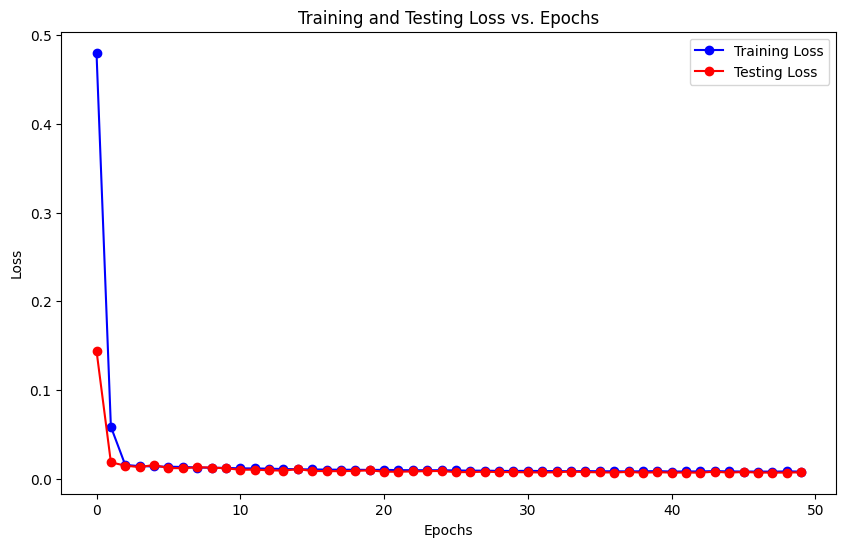

In [15]:
# Plotting Training and Testing Loss vs. Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Testing Loss')
plt.title('Training and Testing Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
